# AAI Mini Project - Self-driving Jet Racer

## Project setup


In [14]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib as mpl
import random
import PIL
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

dataset_dir = 'Dataset 3'
dataset_dir = os.path.join(os.getcwd(), dataset_dir)
print(dataset_dir)

/Users/lucavanstraaten/Documents/hhs/minor/Applied Artificial Intelligence/lab/project/Dataset 3


## Collecting images

the images are stored in the folder `Dataset` and the labels are the filename of the images


In [15]:
# Load the dataset, the folder contains all the images and the filename is the labels comma separated: "steering angle, throttle, image number.png"
# ignore all non png files

# create a list of all the files in the dataset folder
Dataset = []

for file in os.listdir(dataset_dir):
    if file.endswith(".png"):
        # add the file to the list
        Dataset.append(file)

# create a dataframe with the dataset
df = pd.DataFrame(Dataset, columns=['filename'])

# split the filename into 3 columns: steering angle, throttle, image number. but also keep the original filename
df[['steering_angle', 'throttle', 'image_number']] = df.filename.str.split(",",expand=True,)
df['image_number'] = df['image_number'].str.replace('.png', '')

# convert the columns to float
df['steering_angle'] = df['steering_angle'].astype(float)
df['throttle'] = df['throttle'].astype(float)

# convert image number to int
df['image_number'] = df['image_number'].astype(int)

# remove the filename column
# df = df.drop(['filename'], axis=1)

# sort the dataframe by image number
df = df.sort_values(by=['image_number'])

# reset the index
df = df.reset_index(drop=True)

# print the first 5 rows
df.head()


/var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/ipykernel_10375/4250320461.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_number'] = df['image_number'].str.replace('.png', '')


,filename,steering_angle,throttle,image_number
0,"-0.17,-0.62,221.png",-0.17,-0.62,221
1,"0.04,-0.62,222.png",0.04,-0.62,222
2,"-0.03,-0.53,223.png",-0.03,-0.53,223
3,"-0.49,-0.67,224.png",-0.49,-0.67,224
4,"-0.5,-0.62,225.png",-0.50,-0.62,225


## Preprocessing the images


In [16]:
def preprocess(image):
    assert image.shape == (224,224,3)
    # crop the top 80 pixels
    image = image[80:,:,:]
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # resize to 64x64
    image = cv2.resize(image, (32, 32))
    # invert the image
    image = 255 - image
    # reduse the bit depth
    image = image // 16
    # Scale the images to the range of [0, 1]
    image = image / (255.0 / 16.0)
    return image

## Creating the dataset

In [17]:
# now save the images in a np.array data and the labels in a np.array data_labels
# data_labels = [steering_angle, throttle]
data = []
data_labels = []

for _, row in df.iterrows():
    # read the image and put it through the preprocessing function
    image = preprocess(cv2.imread(os.path.join(dataset_dir, row['filename'])))
    # add the image to the data array
    data.append(image)
    # add the labels to the data_labels array
    data_labels.append([row['steering_angle'], row['throttle']])

# convert the data and data_labels to np.array
data = np.array(data)
data_labels = np.array(data_labels)

# randomize the order of the data and data_labels, so that the training and validation set are not ordered. but make sure labels and data are still matching
randomize = np.arange(len(data)) # create an array with the length of the data
np.random.shuffle(randomize) # shuffle the array
data = data[randomize] # shuffle the data by the randomize array
data_labels = data_labels[randomize] # shuffle the data_labels by the randomize array

# print the shape of the data and data_labels
print(data.shape)
print(data_labels.shape)

(597, 32, 32)
(597, 2)


In [18]:
# check the max and min values of the labels
print(np.max(data_labels[:,0]))
print(np.min(data_labels[:,0]))
print(np.max(data_labels[:,1]))
print(np.min(data_labels[:,1]))

1.0
-0.96
0.0
-1.0


In [19]:
# we flip the sign of the steering angle and the throttle so that left is negative and right is positive, and the throttle is negative when braking (going backwards) and positive when accelerating
data_labels[:,1] = -data_labels[:,1]

## Removing the outliers

remove the outliers (extreme values) from the data and data_labels

we will remove top and bottom 10% of the data

In [20]:
# remave all the images ware:
# steering angle is < -0.9 or > 0.9
# throttle is < 0.1 or > 0.9

# create a mask
mask = (data_labels[:,0] > -0.9) & (data_labels[:,0] < 0.9) & (data_labels[:,1] > 0.1) & (data_labels[:,1] < 0.9)

# apply the mask
data = data[mask]
data_labels = data_labels[mask]



## Data augmentation


In [21]:
# we note that we can easily create more data by flipping the images and changing the steering angle sign

# create a new array with the flipped images
data_flipped = np.flip(data, axis=2)

# create a new array with the flipped labels
data_labels_flipped = np.copy(data_labels)
data_labels_flipped[:,0] = -data_labels_flipped[:,0]

# now we can add the flipped images to the data and data_labels
data = np.concatenate((data, data_flipped), axis=0)
data_labels = np.concatenate((data_labels, data_labels_flipped), axis=0)

# print the shape of the data and data_labels
print(data.shape)
print(data_labels.shape)

(1132, 32, 32)
(1132, 2)


## Checkin the dataset

we have a little less about 1000 images in the dataset and we want to know the distribution of the labels


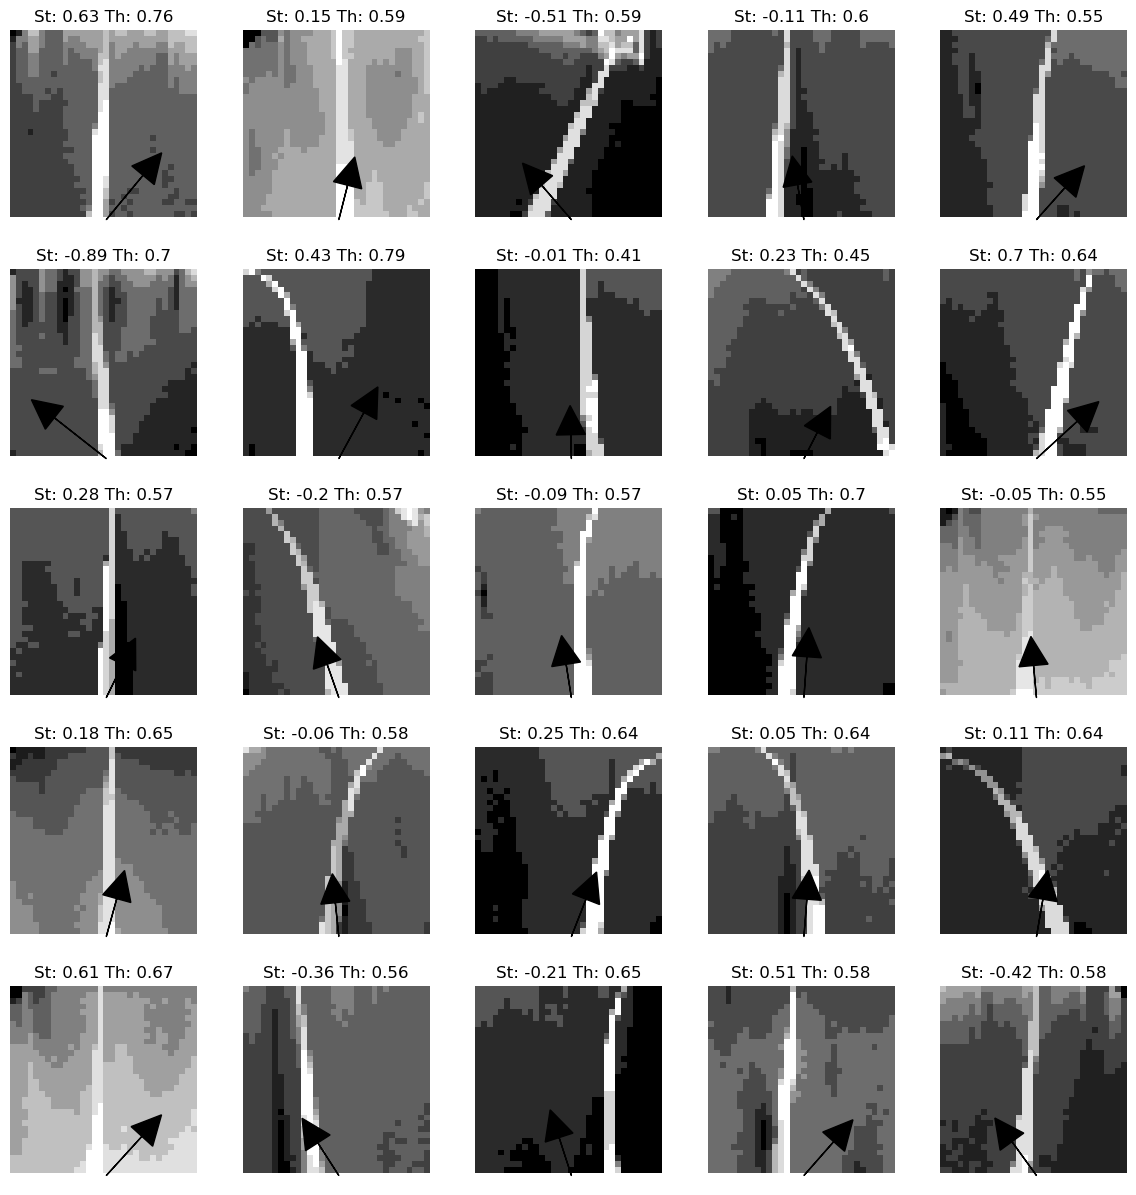

In [22]:
# plot 25 random images and their labels
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, data.shape[0])
    axs[i].imshow(data[index], cmap='gray')
    axs[i].set_title("St: " + str(data_labels[index][0]) + " Th: " + str(data_labels[index][1]))
    # plot the image, the steering angle and throttle and the real steering angle and throttle
    # also draw a arrow with the steering angle and throttle
    # the arrow will be baced on the middle bottom of the image and will point up for throttle and left or right for steering angle
    # the length of the arrow will be the throttle and the angle of the arrow will be the steering angle
    # make arrow position relative to the image size
    arrow_x = data[index].shape[0]/2
    arrow_y = data[index].shape[1]
    axs[i].arrow(arrow_x, arrow_y, data_labels[index][0]*10, -data_labels[index][1]*10, head_width=5, head_length=5, fc='k', ec='k')
    axs[i].axis('off')

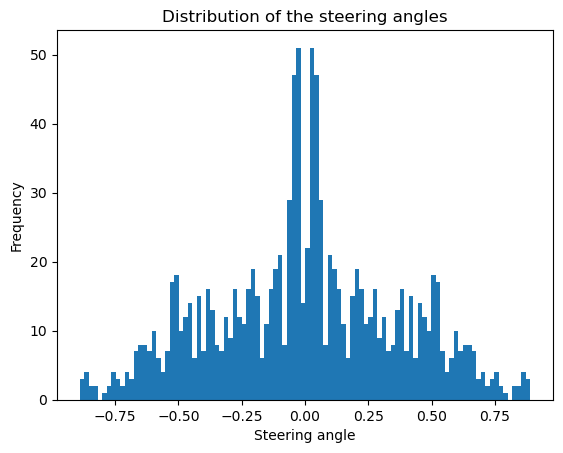

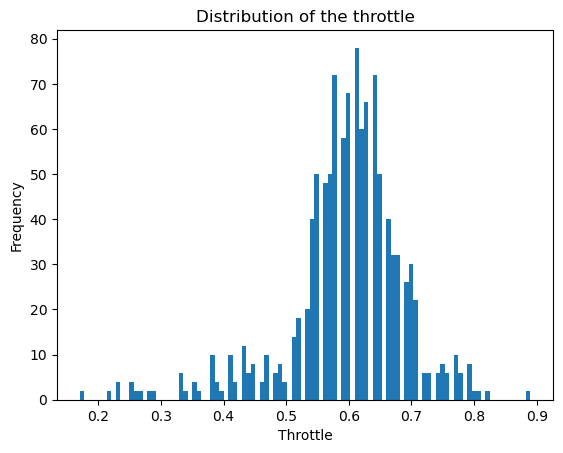

In [23]:
# plot the distribution of the steering angles
plt.hist(data_labels[:,0], bins=100)
plt.title("Distribution of the steering angles")
plt.xlabel("Steering angle")
plt.ylabel("Frequency")
plt.show()

# plot the distribution of the throttle
plt.hist(data_labels[:,1], bins=100)
plt.title("Distribution of the throttle")
plt.xlabel("Throttle")
plt.ylabel("Frequency")
plt.show()

# Splitting the dataset

We want to split the dataset into test and train dataset
We will use 80% of the dataset for training and 20% for testing

We then split the train into training and validation dataset


In [24]:
# split the data into test and train and validation
X_train, X_test, y_train, y_test = train_test_split(data, data_labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# print the shape of the data and data_labels
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(814, 32, 32)
(814, 2)
(204, 32, 32)
(204, 2)
(114, 32, 32)
(114, 2)


## Making the model

we will use a simple CNN model to train the dataset


In [25]:
image_shape = X_train[0].shape

print(image_shape)

# make CNN the model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=256, kernel_size=7, strides=2, padding="same", activation="relu", input_shape=(image_shape[0], image_shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.AveragePooling2D(pool_size=3, strides=2, padding="same"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2, activation="linear"))

# compile the model
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# print the model summary
model.summary()


(32, 32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       12800     
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 128)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          73792     
                                             

## Training the model

In [31]:
# Training the model, and after every epoch we update the history and plot the training and validation loss and accuracy, we also set the dropout rate to 0.5
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), verbose=1, shuffle=True)

Epoch 1/500
26/26 [==============================] - 1s 54ms/step - loss: 0.0712 - mae: 0.1760 - val_loss: 0.0753 - val_mae: 0.1845
Epoch 2/500
26/26 [==============================] - 1s 56ms/step - loss: 0.0713 - mae: 0.1763 - val_loss: 0.0749 - val_mae: 0.1832
Epoch 3/500
26/26 [==============================] - 1s 55ms/step - loss: 0.0706 - mae: 0.1757 - val_loss: 0.0751 - val_mae: 0.1833
Epoch 4/500
26/26 [==============================] - 1s 51ms/step - loss: 0.0712 - mae: 0.1767 - val_loss: 0.0749 - val_mae: 0.1831
Epoch 5/500
26/26 [==============================] - 2s 63ms/step - loss: 0.0706 - mae: 0.1752 - val_loss: 0.0747 - val_mae: 0.1837
Epoch 6/500
26/26 [==============================] - 1s 55ms/step - loss: 0.0715 - mae: 0.1770 - val_loss: 0.0748 - val_mae: 0.1826
Epoch 7/500
26/26 [==============================] - 2s 62ms/step - loss: 0.0714 - mae: 0.1765 - val_loss: 0.0747 - val_mae: 0.1820
Epoch 8/500
26/26 [==============================] - 1s 52ms/step - loss: 0.

In [27]:
# Make a sound come from my mac when the training is done
os.system('say "The training is done"')

0

# check the training history

see if the model is overfitting.

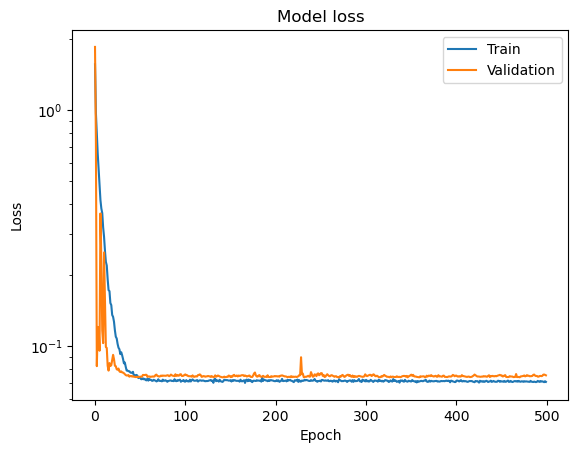

Final loss on validation set: 0.07546093314886093
Final mean absolute error on validation set: 0.18436697125434875


In [28]:
# plot the training and validation loss for each epoch
log = True
if log:
    plt.semilogy(history.history['loss'])
    plt.semilogy(history.history['val_loss'])
else:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# print the final loss and mean absolute error on the validation set
loss, mae = model.evaluate(X_val, y_val, verbose=0)
print("Final loss on validation set: {}".format(loss))
print("Final mean absolute error on validation set: {}".format(mae))

## revisions

### Version 1: 1st revision

- Final loss on validation set: 0.1474226713180542
- Final mean absolute error on validation set: 0.27334269881248474

### Version 1: 2nd revision

- Final loss on validation set: 0.10843917727470398
- Final mean absolute error on validation set: 0.2342437356710434

### Version 1: 3rd revision

- Final loss on validation set: 0.14303547143936157
- Final mean absolute error on validation set: 0.2705163061618805

### Version 1: 4th revision

- Final loss on validation set: 1.0668240785598755
- Final mean absolute error on validation set: 0.9141104221343994

### Version 1: 5th revision

- Final loss on validation set: 0.10493263602256775
- Final mean absolute error on validation set: 0.21330223977565765


### Version 1: 6th revision

- Final loss on validation set: 0.07768958061933517
- Final mean absolute error on validation set: 0.19344942271709442

### Version 1: 7th revision

- Final loss on validation set: 0.07755456864833832
- Final mean absolute error on validation set: 0.1881050020456314


1/1 [==============================] - 0s 16ms/step


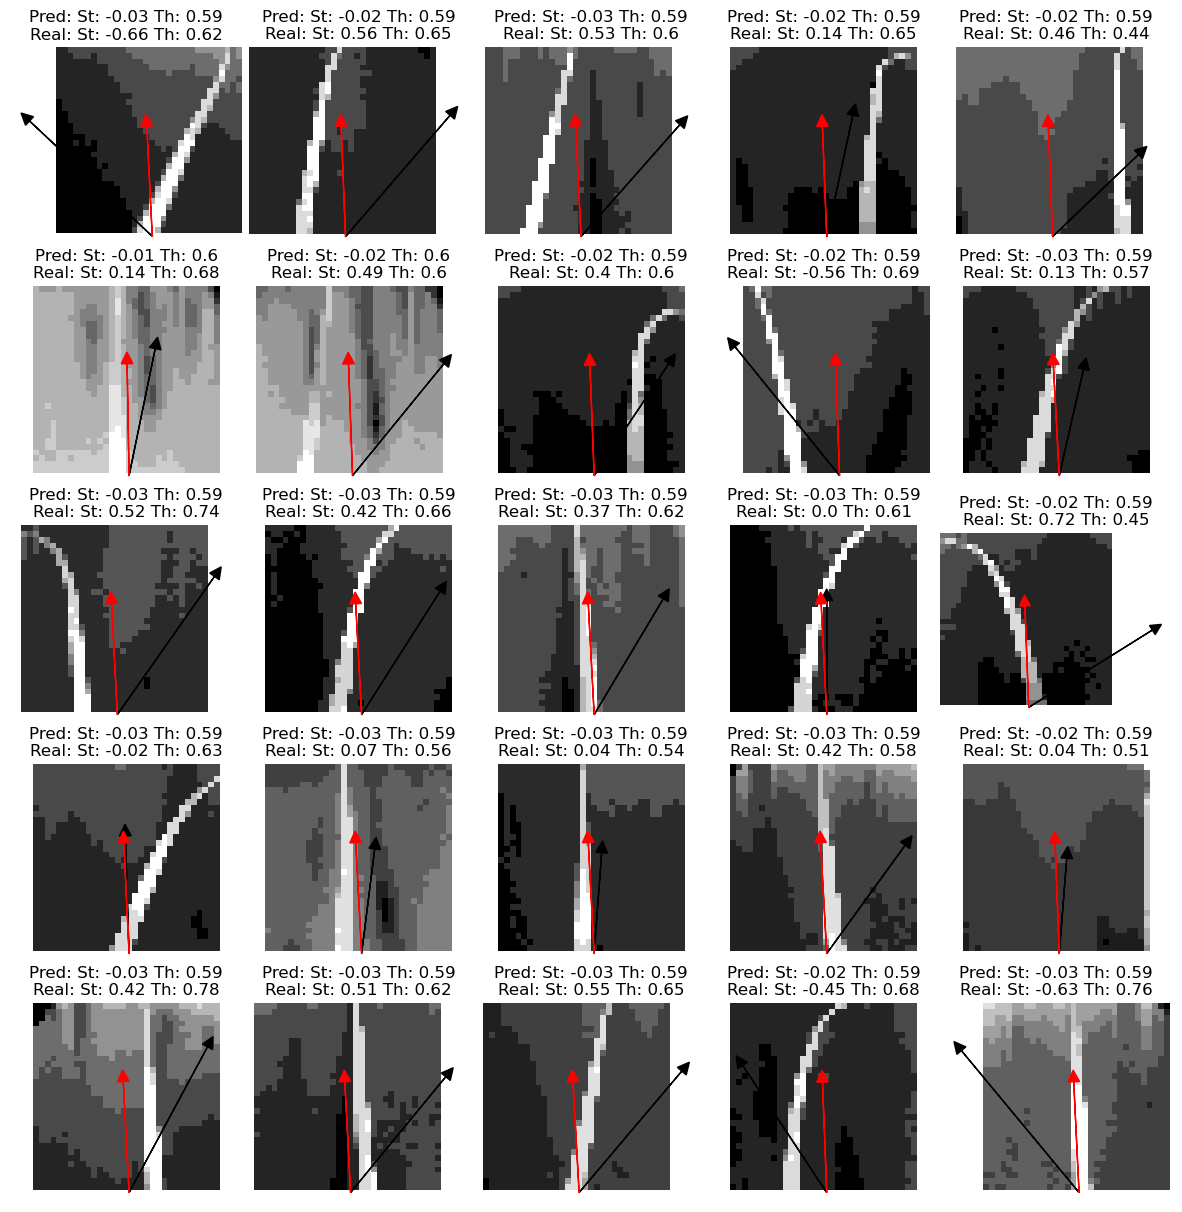

In [29]:
# the position of the arrow will be the middle bottom of the image, so the x position of the arrow will be the width of the image divided by 2
arrow_x = image_shape[1]/2
arrow_y = image_shape[0]

# now take a few images from the val set and predict the steering angle and throttle
# plot the image and the predicted steering angle and throttle and the real steering angle and throttle
fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, X_val.shape[0])
    axs[i].imshow(X_val[index], cmap='gray')
    # predict the steering angle and throttle for the image (array of size 12288)
    st = model.predict(X_val[index].reshape(1, image_shape[0], image_shape[1], 1))[0][0]
    th = model.predict(X_val[index].reshape(1, image_shape[0], image_shape[1], 1))[0][1]
    axs[i].set_title("Pred: St: " + str(round(st, 2)) + " Th: " + str(round(th, 2)) + "\nReal: St: " + str(y_val[index][0]) + " Th: " + str(y_val[index][1]))
    axs[i].axis('off')
    # plot the image, the predicted steering angle and throttle and the real steering angle and throttle
    # also draw a arrow with the predicted steering angle and throttle
    # the arrow will be baced on the middle bottom of the image and will point up for throttle and left or right for steering angle
    # the length of the arrow will be the throttle and the angle of the arrow will be the steering angle
    # the length of the arrow will be between 0 and 1
    # the angle of the arrow will be between -1 and 1
    axs[i].arrow(arrow_x, arrow_y, y_val[index][0]*32, -y_val[index][1]*32, head_width=2, head_length=2, fc='k', ec='k')
    axs[i].arrow(arrow_x, arrow_y, st*32, -th*32, head_width=2, head_length=2, fc='r', ec='r')
    


## saving the model

Convert your model (in the variable `model`) and save the `.tflite` file

In [30]:
output_filename = 'mini_proj_model_v01_07.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()

# This will save your model with the a file name tflite_model_fp16_file.tflite. You can uplaod this model file
# in your JetRacer to run it on the NVIDIA Jetson Nano.

with open(output_filename, 'wb') as f:
    f.write(tflite_fp16_model)


INFO:tensorflow:Assets written to: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmp_ws6uewu/assets


INFO:tensorflow:Assets written to: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmp_ws6uewu/assets
2023-01-10 18:15:18.827328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-10 18:15:18.827780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-10 18:15:18.830853: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmp_ws6uewu
2023-01-10 18:15:18.838484: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2023-01-10 18:15:18.838615: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/gd/_tzcwhnj41j_nysfjnpl80sc0000gn/T/tmp_ws6uewu
2023-01-10 18:15:18.853396: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-01-10 18:15:18.857087: I tensorflow/cc/saved_model/load